Travail réalisé par ALONSO Caroline (ALOC18620100), BAUDOUIN Romain (BAUR25120100) & VAN HYLCKAMA Pedro (VANP15110101)

# 0 - Présentation du sujet et mise en place du projet

Nous avons choisi de faire de la classification supervisée sur les panneaux routiers dans un contexte de sécurité routière.

Pour cela nous avons 43 classes (allant de 0 à 42) étiquettées de la manière suivante :

0. Limite de vitesse (20 km/h)
1. Limite de vitesse (30 km/h)
2. Limite de vitesse (50 km/h)
3. Limite de vitesse (60 km/h)
4. Limite de vitesse (70 km/h)
5. Limite de vitesse (80 km/h)
6. Fin de limitation de vitesse (80 km/h)
7. Limite de vitesse (100 km/h)
8. Limite de vitesse (120 km/h)
9. Interdiction de dépasser
10. Interdiction de dépasser pour les véhicules de plus de 3,5 tonnes
11. Priorité à la prochaine intersection
12. Route prioritaire
13. Cédez le passage
14. Arrêt
15. Interdiction de circuler
16. Interdiction aux véhicules de plus de 3,5 tonnes
17. Sens interdit
18. Danger général
19. Virage dangereux à gauche
20. Virage dangereux à droite
21. Double virage
22. Chaussée déformée
23. Route glissante
24. Rétrécissement de chaussée par la droite
25. Travaux
26. Feux tricolores
27. Passage pour piétons
28. Enfants
29. Passage pour cyclistes
30. Risque de neige ou de verglas
31. Passage d'animaux sauvages
32. Fin de toutes les interdictions imposées aux véhicules en mouvement
33. Tourner à droite
34. Tourner à gauche
35. Tout droit
36. Tout droit ou à droite
37. Tout droit ou à gauche
38. Obligation de contourner à droite
39. Obligation de contourner à gauche
40. Sens giratoire obligatoire
41. Fin d'interdiction de dépasser
42. Fin d'interdiction de dépasser pour les véhicules de plus de 3,5 tonnes

Les images sont séparées en trois dossiers : Train (qui sera ensuite divisé pour avoir des données d'entrainement et des données de validation), Test (qui sera donc utilisé pour les tests du modèle) et Meta (qui ne sera pas utilisé).

Les modèles seront présentés par la suite.

Tout d'abord, nous installons et importons tout ce dont nous aurons besoin par la suite.

In [ ]:
pip install opendatasets

In [ ]:
pip install opencv-python-headless

In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import random
import shutil
import tensorflow as tf
import joblib
from google.colab import files
from PIL import Image, ImageEnhance, ImageFilter
from google.colab.patches import cv2_imshow
from google.colab import files
from keras import layers, models
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

Informations pour importer le dataset :
  - username : pedrovanhylckama
  - key : 71b9da1af5b7f28a485d5ddba5f6f268



# Récupération des données
Nous récupérons les données des panneaux routiers depuis le site Kaggle.

In [ ]:
# https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

# Nettoyer l'ancien dataset si nécessaire
#shutil.rmtree('./gtsrb-german-traffic-sign')

# Télécharger
od.download("https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign",force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pedrovanhylckama
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


100%|██████████| 612M/612M [00:34<00:00, 18.6MB/s]


## 1 - Préparation des données

Nous avons traité les images de la façon suivante :
 - **Nettoyage**
    - *Valeurs manquantes* en s'assurant qu'il n'y ait pas de données/étiquettes manquantes
    - *Valeurs aberrantes* en s'assurant que toutes les étiquettes sont correctes
 - **Formatage des données**
    - *Taille des images* avec un resize de toutes les images en 50x50
 - **Equilibrage des classes** (*réduction* et *augmentation*):
    - Transformation photométrique (comme le *contraste*, *saturation*, *couleur noir/blanc*)
    - Transformation par occlusion (masquage aléatoire de certaines parties de l'image pour simuler une obstruction)
    - Transformation géométrique (rotation)




# Chargement des données

In [ ]:
# Dossiers racine contenant les images
rootImageDirTrain = 'gtsrb-german-traffic-sign/Train'
rootImageDirTest = 'gtsrb-german-traffic-sign/Test'

# Lecture des fichiers CSV
data_train = pd.read_csv("gtsrb-german-traffic-sign/Train.csv")
data_test = pd.read_csv("gtsrb-german-traffic-sign/Test.csv")
data_meta = pd.read_csv("gtsrb-german-traffic-sign/Meta.csv")

# Equilibrage des classes (réduction et augmentation)

Dans notre cas, nous prenons pour chaque classe le même nombre d'images.

Nous faisons donc une réduction pour cela.

Ce nombre est défini par le nombre d'images contenus dans la plus petite classe (210 images).

L'augmentation sera abordé par la suite lors des transformations appliquées.

In [ ]:
# Trouver la taille de la plus petite classe
min_count = data_train['ClassId'].value_counts().min()

# Sélectionner min_count images par ClassId
data_train = data_train.groupby('ClassId').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

# Vérifier le résultat
print(data_train.shape)

# Lire le début du fichier csv
print(data_train.head(10))
print(data_test.head(10))
print(data_meta.head(10))

(9030, 8)
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     29      30       6       6      24      25        0   
1     56      54       5       5      50      49        0   
2     69      70       7       6      63      64        0   
3     60      64       5       6      55      59        0   
4     27      26       6       5      22      21        0   
5     31      30       5       6      26      25        0   
6     38      38       5       6      32      33        0   
7     35      38       5       6      30      33        0   
8     36      36       6       5      30      30        0   
9     54      56       5       5      48      50        0   

                            Path  
0  Train/0/00000_00001_00000.png  
1  Train/0/00000_00005_00022.png  
2  Train/0/00000_00002_00024.png  
3  Train/0/00000_00006_00019.png  
4  Train/0/00000_00002_00000.png  
5  Train/0/00000_00005_00005.png  
6  Train/0/00000_00001_00015.png  
7  Train/0/00000_00006_00002.png  
8  

# Vérification de l'équilibrage des classes

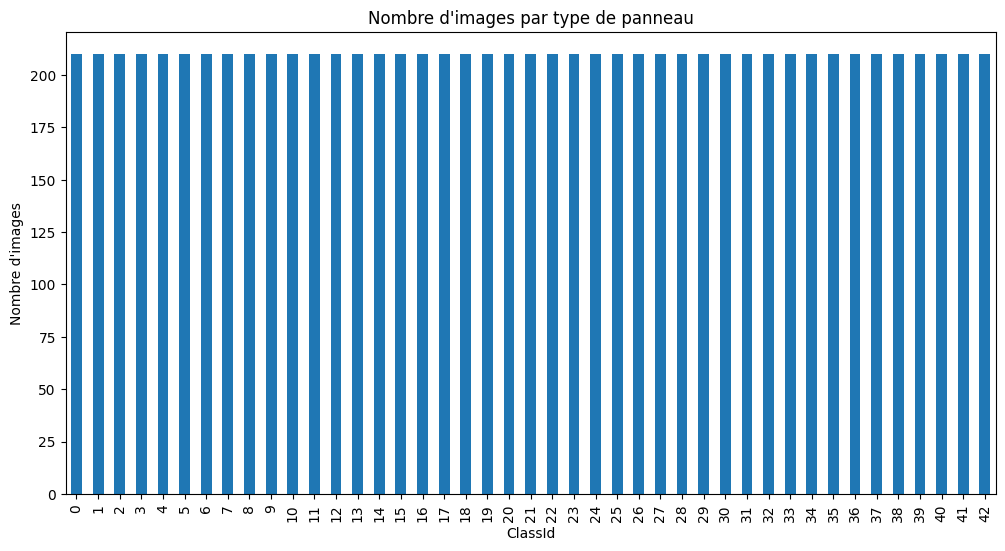

In [ ]:
# Compter le nombre d'image pour chaque classId
compte_classid = data_train['ClassId'].value_counts()

# Afficher les résultats dans un graphique
plt.figure(figsize=(12, 6))
compte_classid.sort_index().plot(kind='bar')
plt.xlabel('ClassId')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par type de panneau')
plt.xticks(rotation=90)
plt.show()

 # Vérification de la présence de valeur nulles

In [ ]:
# Vérifier s'il y a des valeurs nulles
print(data_train.isnull().any())
print(data_test.isnull().any())
print(data_meta.isnull().any())

# Meta a une valeur nulle que nous affichons
# Nous ne l'utiliserons pas par la suite, donc nous ne faisons pas plus de traitement
print(data_meta[data_meta.isnull().any(axis=1)])

Width      False
Height     False
Roi.X1     False
Roi.Y1     False
Roi.X2     False
Roi.Y2     False
ClassId    False
Path       False
dtype: bool
Width      False
Height     False
Roi.X1     False
Roi.Y1     False
Roi.X2     False
Roi.Y2     False
ClassId    False
Path       False
dtype: bool
Path       False
ClassId    False
ShapeId    False
ColorId    False
SignId      True
dtype: bool
           Path  ClassId  ShapeId  ColorId SignId
24  Meta/30.png       30        0        0    NaN


# Comparatif des étiquettes (CSV) et des fichiers présents
Ici, nous nous assurons que chaque image présente dans les sous-dossiers sont bien étiquetées dans le fichier csv correspondant.

In [ ]:
# Lister toutes les images dans les dossiers
def listAllImages(root_dir,isTest):
    image_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.png'):
                if isTest:
                  image_paths.append(os.path.join(root.split("/")[1], file).replace('\\', '/'))
                else:
                  image_paths.append(os.path.join(root.split("/")[1]+"/"+os.path.basename(root)+"/", file).replace('\\', '/'))
    return image_paths

# Vérifier que chaque image dans le dossier est étiquetée
def checkAllImagesLabeled(image_paths, labeled_paths):
    unlabeled_images = []
    labeled_set = set(labeled_paths)
    for image_path in image_paths:
        if image_path not in labeled_set:
            unlabeled_images.append(image_path)
    return unlabeled_images

def areImagesLabeled(root_dir, dataset, isTest=False):
    # Obtenir la liste de toutes les images dans les dossiers
    all_image_paths = listAllImages(root_dir,isTest)
    # Obtenir la liste des chemins d'images dans le fichier CSV
    csv_image_paths = dataset['Path'].tolist()
    # Vérifier les images non étiquetées
    unlabeled_images = checkAllImagesLabeled(all_image_paths, csv_image_paths)
    # Afficher les résultats
    if len(unlabeled_images) == 0:
        print("Toutes les images dans les dossiers sont bien étiquetées.")
    else:
        print("Les images suivantes ne sont pas étiquetées :")
        for img in unlabeled_images:
            print(img)

print("Train :")
areImagesLabeled(rootImageDirTrain, dataset=pd.read_csv("gtsrb-german-traffic-sign/Train.csv"))
print("Test :")
areImagesLabeled(rootImageDirTest, dataset=pd.read_csv("gtsrb-german-traffic-sign/Test.csv"), isTest=True)

Train :
Toutes les images dans les dossiers sont bien étiquetées.
Test :
Toutes les images dans les dossiers sont bien étiquetées.


# Transformations appliquées aux images (B&L, Rotation, Saturation...) avec resize

In [ ]:
# Resize des images initiales en modifiant les images du dossier et en mettant à jour le csv
# Nous pourrions exécuter cette fonction dès le début cependant cela est assez long
# Pour aller plus vite, nous effectuons le resize lors de la transformation
# sans changer les images dans le dossier
# Les images transformées seront donc directement enregistrées dans nos vecteurs de données
# Et les lignes correspondantes aux nouvelles images seront ajoutées dans le fichier csv

"""
def resize_and_update_csv(path_list, csv_path):
    # Lire le CSV
    df = pd.read_csv(csv_path)

    for p in path_list:
        image_path = os.path.join('gtsrb-german-traffic-sign', p)  # Utiliser le chemin complet de l'image
        print(f"Traitement de l'image : {image_path}")  # Impression pour débogage
        if os.path.exists(image_path):
            try:
                image = Image.open(image_path)
                new_size = (50, 50)
                resized_image = image.resize(new_size, Image.LANCZOS)

                # Sauvegarder l'image redimensionnée en écrasant l'image d'origine
                resized_image.save(image_path)

                # Mettre à jour les dimensions dans le CSV
                relative_path = p  # Utiliser le chemin relatif directement
                df.loc[df['Path'] == relative_path, 'Width'] = new_size[0]
                df.loc[df['Path'] == relative_path, 'Height'] = new_size[1]
            except Exception as e:
                print(f"Erreur lors du traitement de l'image {image_path}: {e}")
        else:
            print(f"Fichier introuvable : {image_path}")

    # Sauvegarder le CSV mis à jour
    df.to_csv(csv_path, index=False)

# Obtenir les chemins des images à redimensionner
def get_image_paths_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    image_paths = df['Path'].tolist()
    return image_paths, df

# Pour chaque dossier on a les trois étapes suivantes
# Chemin vers le fichier CSV et le dossier racine des images
# Charger les chemins des images
# Appliquer la fonction de redimensionnement et mettre à jour le CSV

csv_path_train = 'gtsrb-german-traffic-sign/Train.csv'
image_paths_train, df_train = get_image_paths_from_csv(csv_path_train)
resize_and_update_csv(image_paths_train, csv_path_train)

csv_path_test = 'gtsrb-german-traffic-sign/Test.csv'
image_paths_test, df_test = get_image_paths_from_csv(csv_path_test)
resize_and_update_csv(image_paths_test, csv_path_test)

csv_path_meta = 'gtsrb-german-traffic-sign/Meta.csv'
image_paths_meta, df_meta = get_image_paths_from_csv(csv_path_meta)
resize_and_update_csv(image_paths_meta, csv_path_meta)
"""

'\ndef resize_and_update_csv(path_list, csv_path):\n    # Lire le CSV\n    df = pd.read_csv(csv_path)\n\n    for p in path_list:\n        image_path = os.path.join(\'gtsrb-german-traffic-sign\', p)  # Utiliser le chemin complet de l\'image\n        print(f"Traitement de l\'image : {image_path}")  # Impression pour débogage\n        if os.path.exists(image_path):\n            try:\n                image = Image.open(image_path)\n                new_size = (50, 50)\n                resized_image = image.resize(new_size, Image.LANCZOS)\n\n                # Sauvegarder l\'image redimensionnée en écrasant l\'image d\'origine\n                resized_image.save(image_path)\n\n                # Mettre à jour les dimensions dans le CSV\n                relative_path = p  # Utiliser le chemin relatif directement\n                df.loc[df[\'Path\'] == relative_path, \'Width\'] = new_size[0]\n                df.loc[df[\'Path\'] == relative_path, \'Height\'] = new_size[1]\n            except Exce

# Création d'une nouvelle image transformée
Ici, nous sauvegardons l'image transformée d'une part dans le dossier de sa classe correspondante lors de sa transformation et d'autre part dans notre variable de données d'entraînement : **data_train**

In [ ]:
def addLineToDataFrame(path, classId):
  global data_train
  new_line = pd.DataFrame({"Width":50, "Height":50, "Roi.X1":0, "Roi.Y1":0,"Roi.X2":0,"Roi.Y2":0, "ClassId":classId, "Path":path}, index=[0])
  data_train = pd.concat([data_train, new_line], ignore_index=True)

# Transformation en noir et blanc

In [ ]:
def blackAndWhiteImage(path, dataset, datasetPath, classId, last=True):
  # Charger l'image
  image = Image.open(path)
  # Convertir en noir et blanc
  image_bl = image.convert('L')
  # Ajouter un nouveau label à l'image
  path_bl = path[path.find("Train"):]
  path_bl = path_bl.split(".")[0] + '_bw.png'
  if(last):
    addLineToDataFrame(path_bl, classId)
  # Sauvegarder le duplicatat
  image_bl.save('gtsrb-german-traffic-sign/' + path_bl)

  return 'gtsrb-german-traffic-sign/' + path_bl

# Saturation de l'image

In [ ]:
def saturateImage(path, dataset, datasetPath, classId, last=True, saturation_factor=2):
    # Charger l'image
    image = Image.open(path)
    # Appliquer la saturation
    enhancer = ImageEnhance.Color(image)
    image_sat = enhancer.enhance(saturation_factor)
    # Ajouter un nouveau label à l'image
    path_sat = path[path.find("Train"):]
    path_sat = path_sat.split(".")[0] + '_sat.png'
    if(last):
      addLineToDataFrame(path_sat, classId)
    # Sauvegarder le duplicatat
    image_sat.save('gtsrb-german-traffic-sign/' + path_sat)

    return 'gtsrb-german-traffic-sign/' + path_sat

# Rendre l'image floue

In [ ]:
def blurImage(path, dataset, datasetPath, classId, last=True, radius=0.8):
    # Charger l'image
    image = Image.open(path)
    # Appliquer le floutage
    blurred_image = image.filter(ImageFilter.GaussianBlur(radius))
    # Ajouter un nouveau label à l'image
    path_blurred = path[path.find("Train"):]
    path_blurred = path_blurred.split(".")[0] + '_blur.png'
    if(last):
      addLineToDataFrame(path_blurred, classId)
    # Sauvegarder le duplicatat
    blurred_image.save('gtsrb-german-traffic-sign/' + path_blurred)

    return 'gtsrb-german-traffic-sign/' + path_blurred


# Obstruer l'image avec des pixels noir

In [ ]:
def obstructImage(path, dataset, datasetPath, classId, last=True, mask_size_ratio=0.1):
    # Charger l'image
    image = cv2.imread(path)
    h, w, _ = image.shape
    mask_h, mask_w = int(h * mask_size_ratio), int(w * mask_size_ratio)
    # Choisir aléatoirement une position pour l'obstruction
    x = np.random.randint(0, w - mask_w)
    y = np.random.randint(0, h - mask_h)
    # Appliquer l'obstruction/le masque (ici un carré noir)
    image[y:y+mask_h, x:x+mask_w] = 0
    # Ajouter un nouveau label à l'image
    path_obstructed = path[path.find("Train"):]
    path_obstructed = path_obstructed.split(".")[0] + '_obs.png'
    if(last):
      addLineToDataFrame(path_obstructed, classId)
    # Sauvegarder le duplicatat
    cv2.imwrite('gtsrb-german-traffic-sign/' + path_obstructed, image)

    return 'gtsrb-german-traffic-sign/' + path_obstructed

# Rotation de l'image

In [ ]:
def rotateImage(path, dataset, datasetPath, classId, last=True, angle_range=(-30, 30)):
    # Charger l'image
    image = Image.open(path)
    # Choisir aléatoirement un angle (compris entre -30 et 30)
    angle = np.random.uniform(angle_range[0], angle_range[1])
    # Appliquer une rotation
    rotated_image = image.rotate(angle, resample=Image.BICUBIC, expand=True)
    # Ajouter un nouveau label à l'image
    path_rotated = path[path.find("Train"):]
    path_rotated = path_rotated.split(".")[0] + '_rot.png'
    if(last):
      addLineToDataFrame(path_rotated, classId)
    # Sauvegarder le duplicatat
    rotated_image.save('gtsrb-german-traffic-sign/' + path_rotated)

    return 'gtsrb-german-traffic-sign/' + path_rotated

# Roulement des transformations
Nous appliquons au maximum une transformation par image.

Chaque image subie une transformation parmi 15 options de transformations, certaines transformations étant des combinaisons de transformations abordées précédemment (par exemple, noir et blanc + flou forment une combinaison possible, cela correspond ci-dessous au cas numéro 5)

In [ ]:
def applytransform(path, index, classId):
  match(index%15):
    case 0:
      blackAndWhiteImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 1:
      blurImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 2:
      saturateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 3:
      obstructImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 4:
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 5:
      path = blackAndWhiteImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      blurImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 6:
      path = blackAndWhiteImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 7:
      path = blackAndWhiteImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      obstructImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 8:
      path = blurImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 9:
      path = blurImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      obstructImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 10:
      path = saturateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 11:
      path = saturateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      obstructImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 12:
      path = obstructImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 13:
      path = blackAndWhiteImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      path = blurImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId, last=False)
      rotateImage(path, data_train, "gtsrb-german-traffic-sign/Train.csv", classId)
      pass
    case 14:
      pass

In [ ]:
def transformClasses():
    taille = len(data_train)
    for i in range(0, taille):
        # Récupérer le chemin d'accès de l'image
        imagePath = 'gtsrb-german-traffic-sign/' + data_train.iloc[i]['Path']
        # Lui appliquer une transformation
        applytransform(imagePath, i, data_train.iloc[i]["ClassId"])

# Vérification de l'équilibrage des classes après transformations

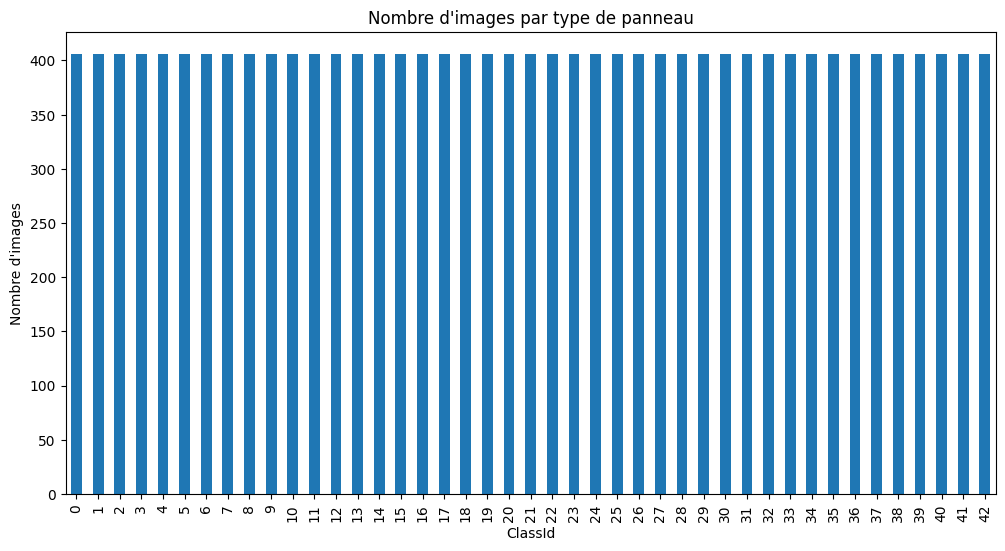

In [ ]:
transformClasses()

# Compter le nombre d'image pour chaque classId
compte_classid = data_train['ClassId'].value_counts()

# Afficher les résultats dans un graphique
plt.figure(figsize=(12, 6))
compte_classid.sort_index().plot(kind='bar')

plt.xlabel('ClassId')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par type de panneau')
plt.xticks(rotation=90)
plt.show()

# Création des données d'entraînement
Ici, nous faisons un resize de toutes nos données d'entraînement, les images transformées et non transformées ont ainsi toutes la même taille.

Nous divisons ensuite nos données entre données d'entraînement et données de validation avec un simple split.

Nos données d'entrainement et de tests étant déjà séparées dans des dossiers différents, nous avons donc séparé nos données d'entrainement et de validation tout aussi simplement, cela est rapide, adapté aux datasets volumineux ce qui correspond à notre cas et permettra de préserver nos ressources computationnelles (bien que d'autres choix soient possibles nous avons choisi de faire ce compromis).


In [ ]:
def createTrainData():
    image_data = []
    image_labels = []

    data_list = list(data_train)
    for index, row in data_train.iterrows():
      try:
        path = row['Path']
        # Récupération de l'image
        image = cv2.imread("gtsrb-german-traffic-sign/" + path)
        image_fromarray = Image.fromarray(image, 'RGB')
        # Resize en 50x50
        resize_image = image_fromarray.resize((50, 50))
        image_data.append(np.array(resize_image))
        image_labels.append(row["ClassId"])

      except:
            print("Error in " + str(index))

    # Changer la liste en numpy array
    image_data = np.array(image_data)
    image_labels = np.array(image_labels)

    # Mélange aléatoire des données
    shuffle_indexes = np.arange(image_data.shape[0])
    np.random.shuffle(shuffle_indexes)
    image_data = image_data[shuffle_indexes]
    image_labels = image_labels[shuffle_indexes]

    X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

    # Normalisation des données issues des images
    X_train = X_train/255
    X_val = X_val/255

    return X_train, y_train, X_val, y_val

In [ ]:
X_train, y_train, X_val, y_val = createTrainData()
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (12220, 50, 50, 3)
X_valid.shape (5238, 50, 50, 3)
y_train.shape (12220,)
y_valid.shape (5238,)


# 2 - Réduction de dimension.

Nous avons tenter d'utiliser la PCA pour réduire les dimensions de nos images, comme ci dessous, cependant nous verrons que les résultats avec cette dernière sont assez mauvais.
Sachant donc que nous avons des données non linéaires, la possibilité à laquelle nous avons pensé est le fait d'utiliser les features extraites suites au pooling effectué dans notre CNN qui permet bien de réduire nos dimensions.

In [ ]:
class PCAReductor():
    def __init__(self, n, x_train):
        self.n_comp = n
        self.pca = PCA(n_components=self.n_comp)
        # Utilisation de np.copy afin d'éviter la shallow copy de X_train
        self.images = np.copy(x_train)

    def pca_reduction(self):
        self.images = self.images.reshape(self.images.shape[0],3*50*50)
        self.pca.fit(self.images)
        print("fitting pca...")
        self.img_transformed = self.pca.transform(self.images)
        return self.img_transformed

    def plot_var(self):
        # Variance expliquée par chaque composante principale
        explained_variance = self.pca.explained_variance_ratio_

        # Visualisation de la variance expliquée
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(explained_variance))
        plt.xlabel('Nombre de composantes')
        plt.ylabel('Variance expliquée cumulée')
        plt.title('Variance expliquée par PCA')
        plt.show()

    def reconstruct_image(self, image, index):

        images_reconstructed = self.pca.inverse_transform(self.img_transformed)
        images_reconstructed = images_reconstructed.reshape(-1, 50, 50, 3)

        plt.figure(figsize=(12, 6))

        # Image originale
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image originale')

        # Image reconstruite
        plt.subplot(1, 2, 2)
        plt.imshow(images_reconstructed[index])
        plt.title('Image reconstruite')

        plt.show()

fitting pca...


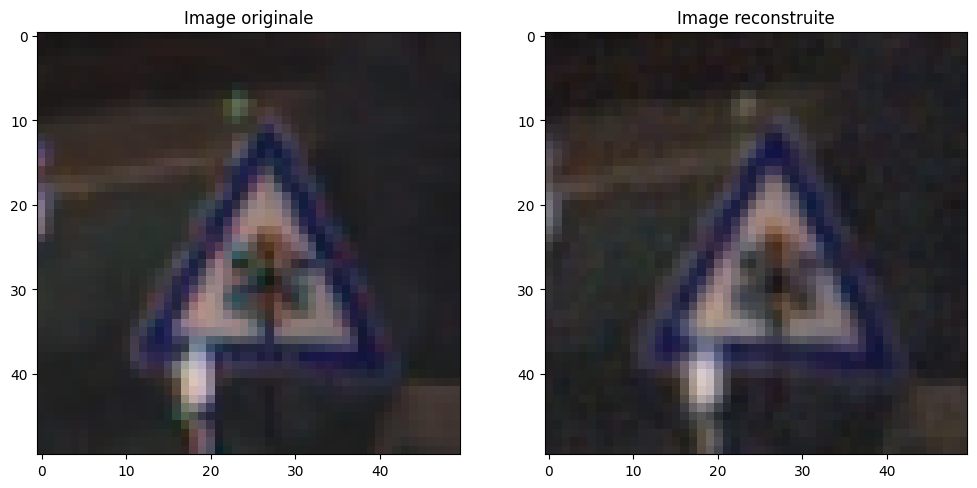

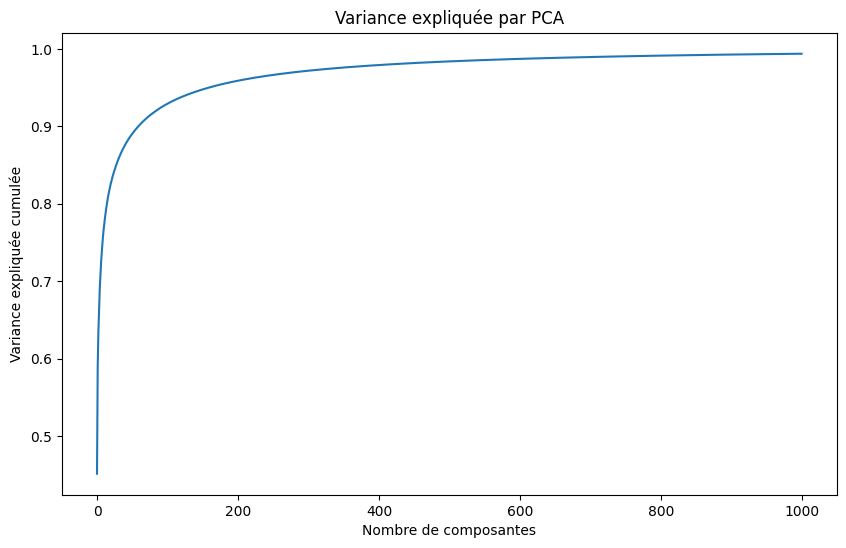

In [ ]:
# Utilisation de la PCA avec 1000 features
pca = PCAReductor(1000,X_train)
X_train_pca = pca.pca_reduction()
# Reconstruction de la première image du dataset
pca.reconstruct_image(X_train[0], 0)
pca.plot_var()

# 3 - Utilisation de trois modèles.

Précision de la stratégie de validation utilisée  (cf. Création des données d'entraînement)

Nous implémenterons les trois modèles suivants :
- *CNN (Convolutional Neural Network)*
- *Random Forest*
- *SVM (Support Vector Machine)*

Pour rappel :

- Les CNN capturent efficacement les relations non-linéaires complexes dans les images, ce qui est crucial pour distinguer nos 43 classes. Généralement, plusieurs couches de convolution sont utilisées, appliquant des filtres de convolution, suivies par des fonctions d'activation non linéaires (comme ReLU) et des opérations de pooling.
- Les Random Forests combinent plusieurs arbres décisionnels pour améliorer la robustesse et réduire le risque de surapprentissage, ce qui aide à gérer la diversité des panneaux routiers. Les Random Forests permettent d'identifier les caractéristiques importantes, ce qui peut être utile pour comprendre quelles caractéristiques des panneaux sont les plus discriminatives.
- Les SVM quant à eux trouvent l'hyperplan qui maximise la marge entre les différentes classes, ce qui est efficace même pour une classification multi-classes complexe comme celle des panneaux routiers.


# Création des données test
Nous devons tout d'abord récupérer et resize les données de test qui serviront à nos prédictions.

In [ ]:
# Création données test
def createTestData():
    test = data_test
    y_test = test["ClassId"].values
    imgs = test["Path"].values
    data =[]

    for img in imgs:
        try:
            image = cv2.imread('gtsrb-german-traffic-sign' + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((50, 50))
            data.append(np.array(resize_image))
        except:
            print("Error in " + img)

    X_test = np.array(data)
    X_test = X_test/255

    return X_test, y_test


In [ ]:
X_test, y_test = createTestData()
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_test.shape (12630, 50, 50, 3)
y_test.shape (12630,)


### CNN

In [ ]:
def create_simple_cnn(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (50, 50, 3)  # Adapter en fonction des données
num_classes = 43  # Nombre de classes de panneaux routiers
cnn_model = create_simple_cnn(input_shape, num_classes)

prediction = cnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))
cnn_model.evaluate(X_test, y_test)

# Prédire les classes pour les données de test
y_pred_cnn = cnn_model.predict(X_test)
# Convertir les prédictions en classes
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Calculer l'exactitude
accuracy_cnn = accuracy_score(y_test, y_pred_cnn_classes)
print(f'CNN Accuracy: {accuracy_cnn}')

Epoch 1/20
382/382 [==============================] - 9s 12ms/step - loss: 2.2900 - accuracy: 0.3903 - val_loss: 0.9083 - val_accuracy: 0.7554
Epoch 2/20
382/382 [==============================] - 2s 6ms/step - loss: 0.6244 - accuracy: 0.8296 - val_loss: 0.4310 - val_accuracy: 0.8839
Epoch 3/20
382/382 [==============================] - 2s 6ms/step - loss: 0.3040 - accuracy: 0.9169 - val_loss: 0.3483 - val_accuracy: 0.9059
Epoch 4/20
382/382 [==============================] - 3s 7ms/step - loss: 0.1653 - accuracy: 0.9519 - val_loss: 0.3170 - val_accuracy: 0.9185
Epoch 5/20
382/382 [==============================] - 3s 7ms/step - loss: 0.1115 - accuracy: 0.9662 - val_loss: 0.2626 - val_accuracy: 0.9339
Epoch 6/20
382/382 [==============================] - 3s 8ms/step - loss: 0.0779 - accuracy: 0.9766 - val_loss: 0.2557 - val_accuracy: 0.9408
Epoch 7/20
382/382 [==============================] - 3s 7ms/step - loss: 0.0590 - accuracy: 0.9807 - val_loss: 0.2488 - val_accuracy: 0.9425
Epoch

## Extraction des features du CNN
Une fois que le CNN a tourné, nous allons récupérer (via la méthode get_layer) une couche de feature extraction pour l'utiliser avec les modèles Random Forest et SVM.


In [ ]:
# Récupérer les features d'entrainement et de tests de la cnn (suite au pooling)
layer_name = 'dense'
intermediate_layer_model = Model(inputs=cnn_model.input,
                                 outputs=cnn_model.get_layer(layer_name).output)
train_features = intermediate_layer_model.predict(X_train)
test_features = intermediate_layer_model.predict(X_test)



395/395 [==============================] - 1s 2ms/step


### Random Forest

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf_model.fit(X_train_flat, y_train)
y_pred_rf = rf_model.predict(X_test_flat)

# Calculer l'exactitude
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

Random Forest Accuracy: 0.6971496437054632


In [ ]:
# Random Forest avec feature extraction
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, max_features='log2', max_depth=20, min_samples_split=5)
X_train_flat_feature = train_features.reshape(X_train.shape[0], -1)
X_test_flat_feature = test_features.reshape(X_test.shape[0], -1)

rf_model.fit(X_train_flat_feature, y_train)
y_pred_rf = rf_model.predict(X_test_flat_feature)

# Calculer l'exactitude
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

Random Forest Accuracy: 0.9252573238321457


Nous avons utilisé GridSearch pour trouver des paramètres optimaux pour la Random Forest (nous avons remis les bonnes valeurs dans la case du dessus pour refaire tourner le modèle plus vite avec directement les bons parametres si besoin)

In [ ]:
# Random Forest avec feature extraction et GridSearch

# Paramètres pour Grid Search
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5]
}
# Initialisation du modèle Random Forest
rf_model = RandomForestClassifier(random_state=42)
# Grid Search avec validation croisée
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_flat_feature, y_train)
# Meilleur modèle et prédictions
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_flat_feature)

# Calculer l'exactitude et afficher les paramètres optimaux
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Optimized Random Forest Accuracy: {accuracy_rf}')
print(f'Best Parameters for Random Forest: {grid_search_rf.best_params_}')


Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Optimized Random Forest Accuracy: 0.9252573238321457
Best Parameters for Random Forest: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 300}


## Application de la PCA aux données test


Avant d'utiliser les features extractions nous avions appliqué la pca, cependant les résultats, visibles par la suite, étaient pires que si nous ne faisions rien.

In [ ]:
pca = PCAReductor(1000, X_test)
X_test_pca = pca.pca_reduction()

En faisant tourner la Random Forest avec les données de la PCA, nous obtenons des métriques très mauvaises.

In [ ]:
# Random Forest avec PCA
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_flat = X_train_pca.reshape(X_train_pca.shape[0], -1)
X_test_flat = X_test_pca.reshape(X_test_pca.shape[0], -1)

rf_model.fit(X_train_flat, y_train)
y_pred_rf = rf_model.predict(X_test_flat)

# Calculer l'exactitude
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

Random Forest Accuracy: 0.054077593032462394


### SVM

In [ ]:
#SVM
svm_model = SVC(kernel='linear', C=1.0, probability=True)

svm_model.fit(X_train_flat, y_train)
y_pred_svm = svm_model.predict(X_test_flat)

# Calculer l'exactitude
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm}')


SVM Accuracy: 0.0444972288202692


In [ ]:
#SVM avec feature extraction
svm_model = SVC(kernel='linear', C=0.1, gamma=1, probability=True)
svm_model.fit(X_train_flat_feature, y_train)
y_pred_svm = svm_model.predict(X_test_flat_feature)

# Calculer l'exactitude
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm}')


SVM Accuracy: 0.9201900237529691


Nous avons utilisé RandomizedSearch pour trouver des paramètres optimaux pour le SVM (nous avons remis les bonnes valeurs dans la case du dessus pour refaire tourner le modèle plus vite avec directement les bons parametres si besoin, ce qui est identique à ce que nous avions fait pour le random forest)

In [ ]:
#SVM avec feature extraction et RandomizedSearch

# Paramètres pour Randomized Search
param_dist_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'poly', 'sigmoid']
}
# Initialisation du modèle SVM
svm_model = SVC(probability=True)
# Randomized Search avec validation croisée
random_search_svm = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist_svm,
                                       n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_svm.fit(X_train_flat_feature, y_train)
# Meilleur modèle et prédictions
best_svm_model = random_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_flat_feature)

# Calculer l'exactitude et afficher les paramètres optimaux
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Optimized SVM Accuracy: {accuracy_svm}')
print(f'Best Parameters for SVM: {random_search_svm.best_params_}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Optimized SVM Accuracy: 0.9247030878859858
Best Parameters for SVM: {'kernel': 'linear', 'gamma': 1, 'C': 0.1}


# Sauvegarder et télécharger les modèles entraînés

In [ ]:
# CNN
cnn_model.save('model_CNN.h5')
files.download('model_CNN.h5')
# Random Forest
joblib.dump(rf_model, 'model_Random_Forest.pkl')
files.download('model_Random_Forest.pkl')
# SVM
joblib.dump(svm_model, 'model_SVM.pkl')
files.download('model_SVM.pkl')

print("Saved models to disk")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved models to disk


# 4 - Evaluation des modèles (via des métriques de validation adéquates)

Nous faisons une *matrice de confusion* (pour cela nous nous sommes basés sur le chapitre 4).

Nous ferons aussi apparaître diverses métriques.
Pour cela nous utiliserons le *rapport fourni par la bibliothèque sklearn*, mais calculerons et afficherons aussi la moyenne des métriques suivantes :
Accuracy, précision, recall/sensitivité, f1-score, spécificité, IoU et le ROCAUC (dont nous ferons aussi apparaitre les courbes) afin qu'elles soient toutes visibles au même endroit, plus facilement, enfin nous afficherons également le nombre d'images de tests mal classifiées.

In [ ]:
def plot_roc_curve(y_test, y_pred, n_classes):
    # Afficher les courbes ROC pour chaque class
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(20, 20))  # Ajuster la taille de la figure
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)
    plt.show()

Évaluation du modèle: CNN
Accuracy: 0.9191
Precision: 0.8818
Recall (Sensitivité): 0.9141
F1-score: 0.8940
Spécificité: 0.8818
IoU: 0.8216
ROC AUC: 0.9561

Classification report for model CNN:
              precision    recall  f1-score   support

           0       0.78      0.97      0.87        60
           1       0.93      0.93      0.93       720
           2       0.87      0.95      0.91       750
           3       0.90      0.90      0.90       450
           4       0.97      0.92      0.95       660
           5       0.90      0.83      0.86       630
           6       0.99      0.84      0.91       150
           7       0.89      0.87      0.88       450
           8       0.87      0.93      0.90       450
           9       0.99      0.97      0.98       480
          10       0.99      0.93      0.96       660
          11       0.91      0.86      0.89       420
          12       0.98      0.94      0.96       690
          13       1.00      0.97      0.99       

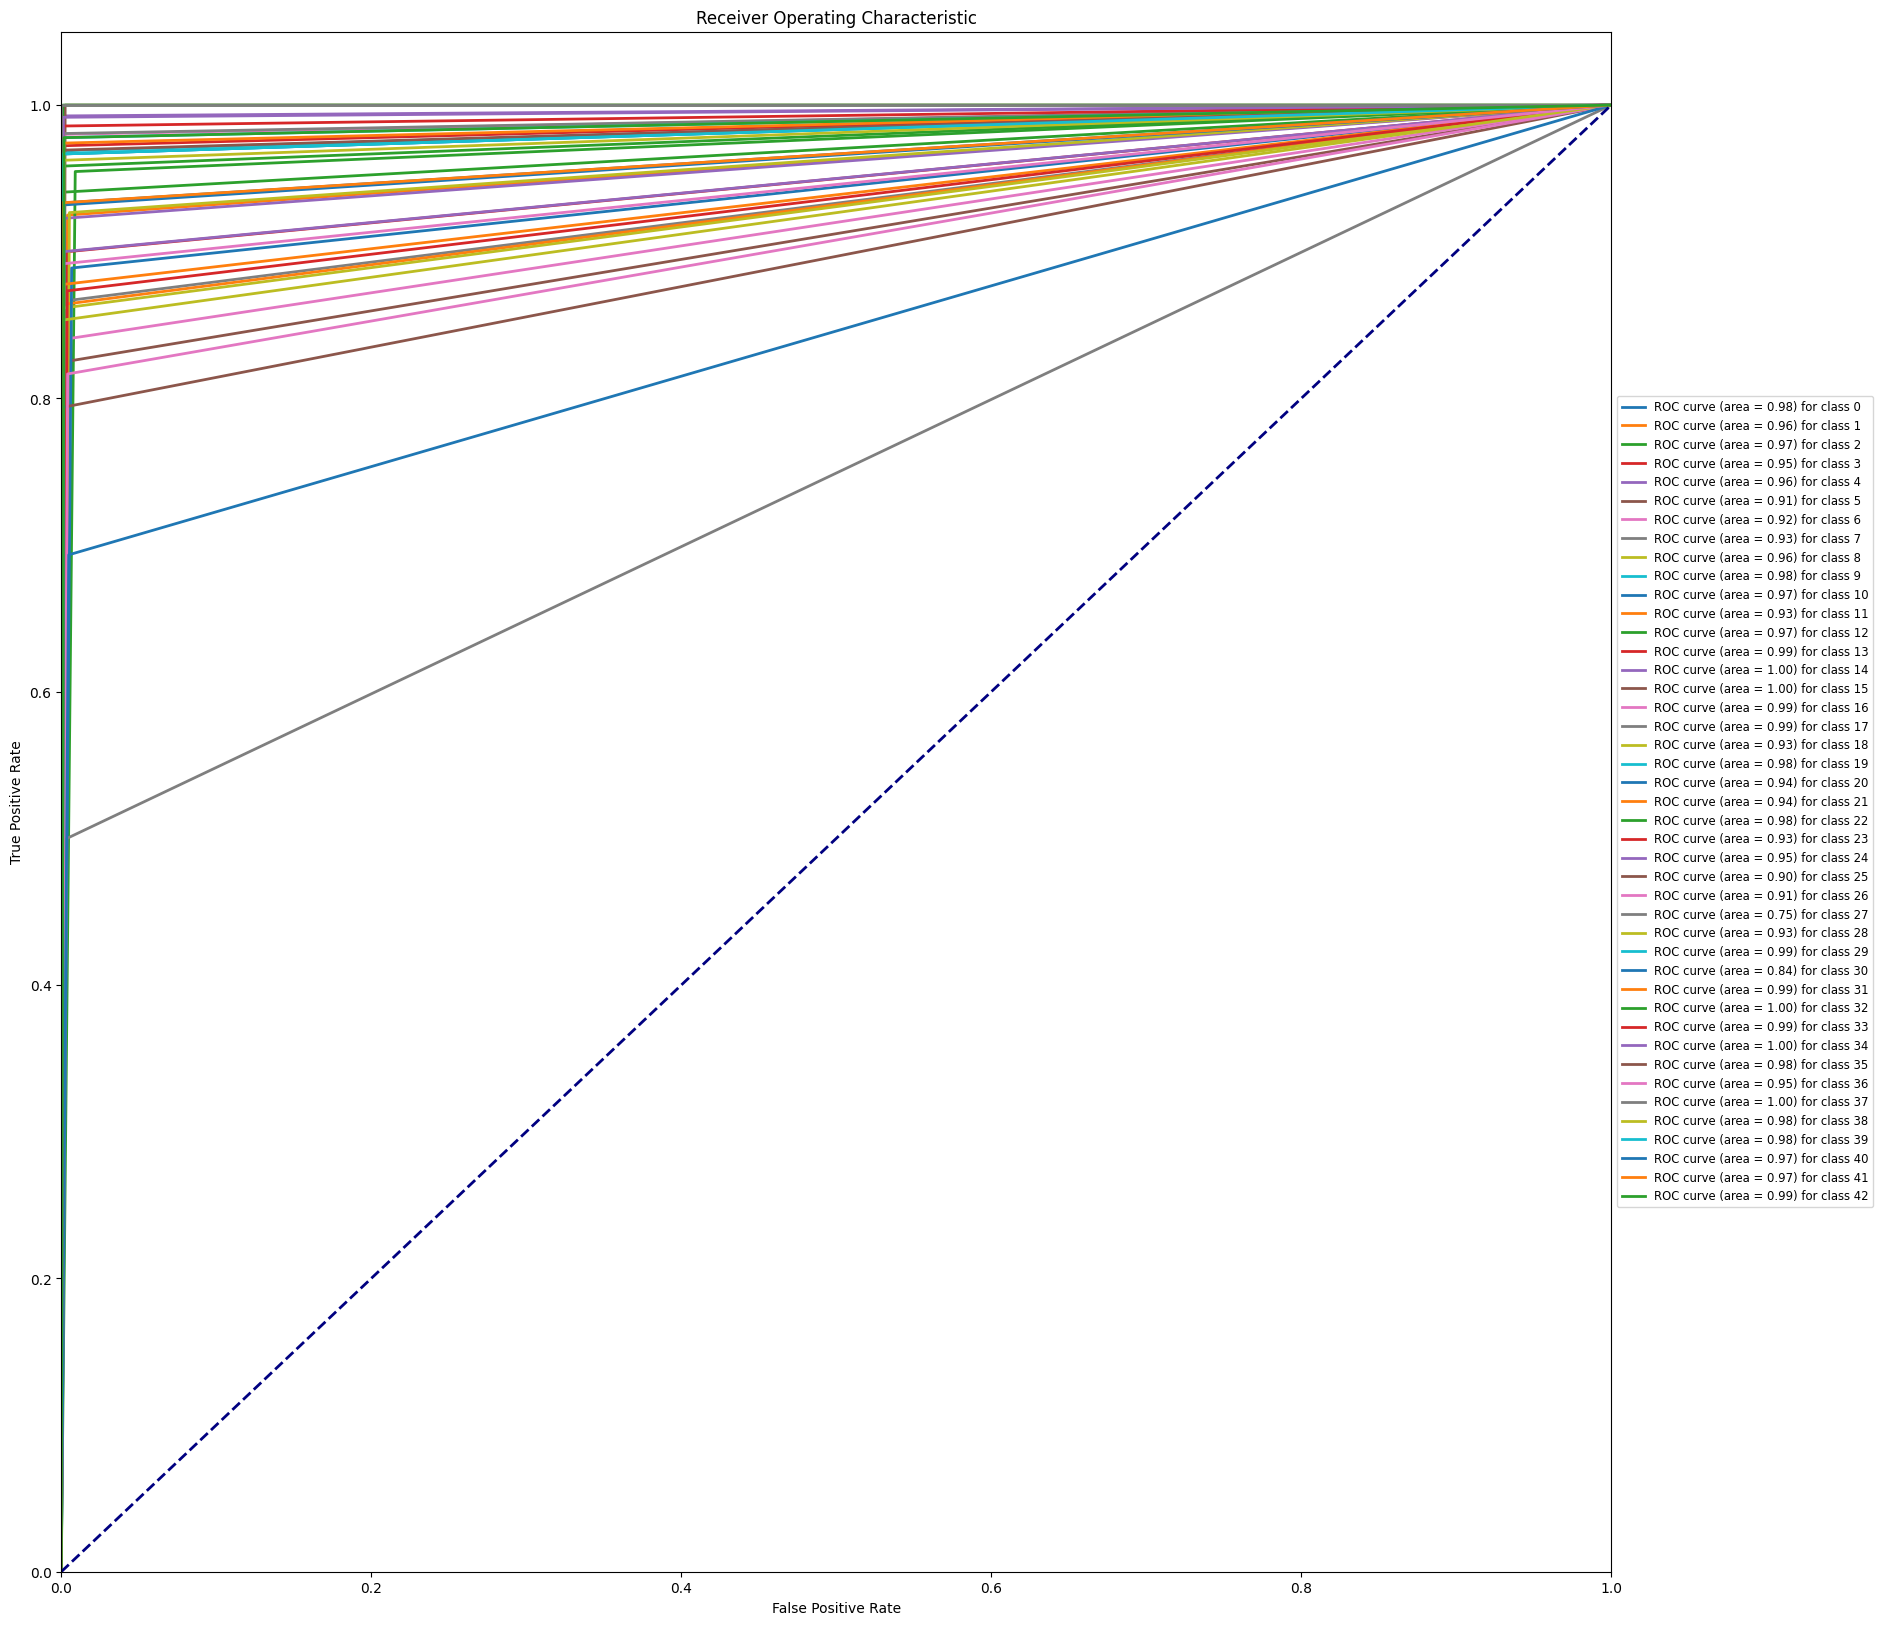

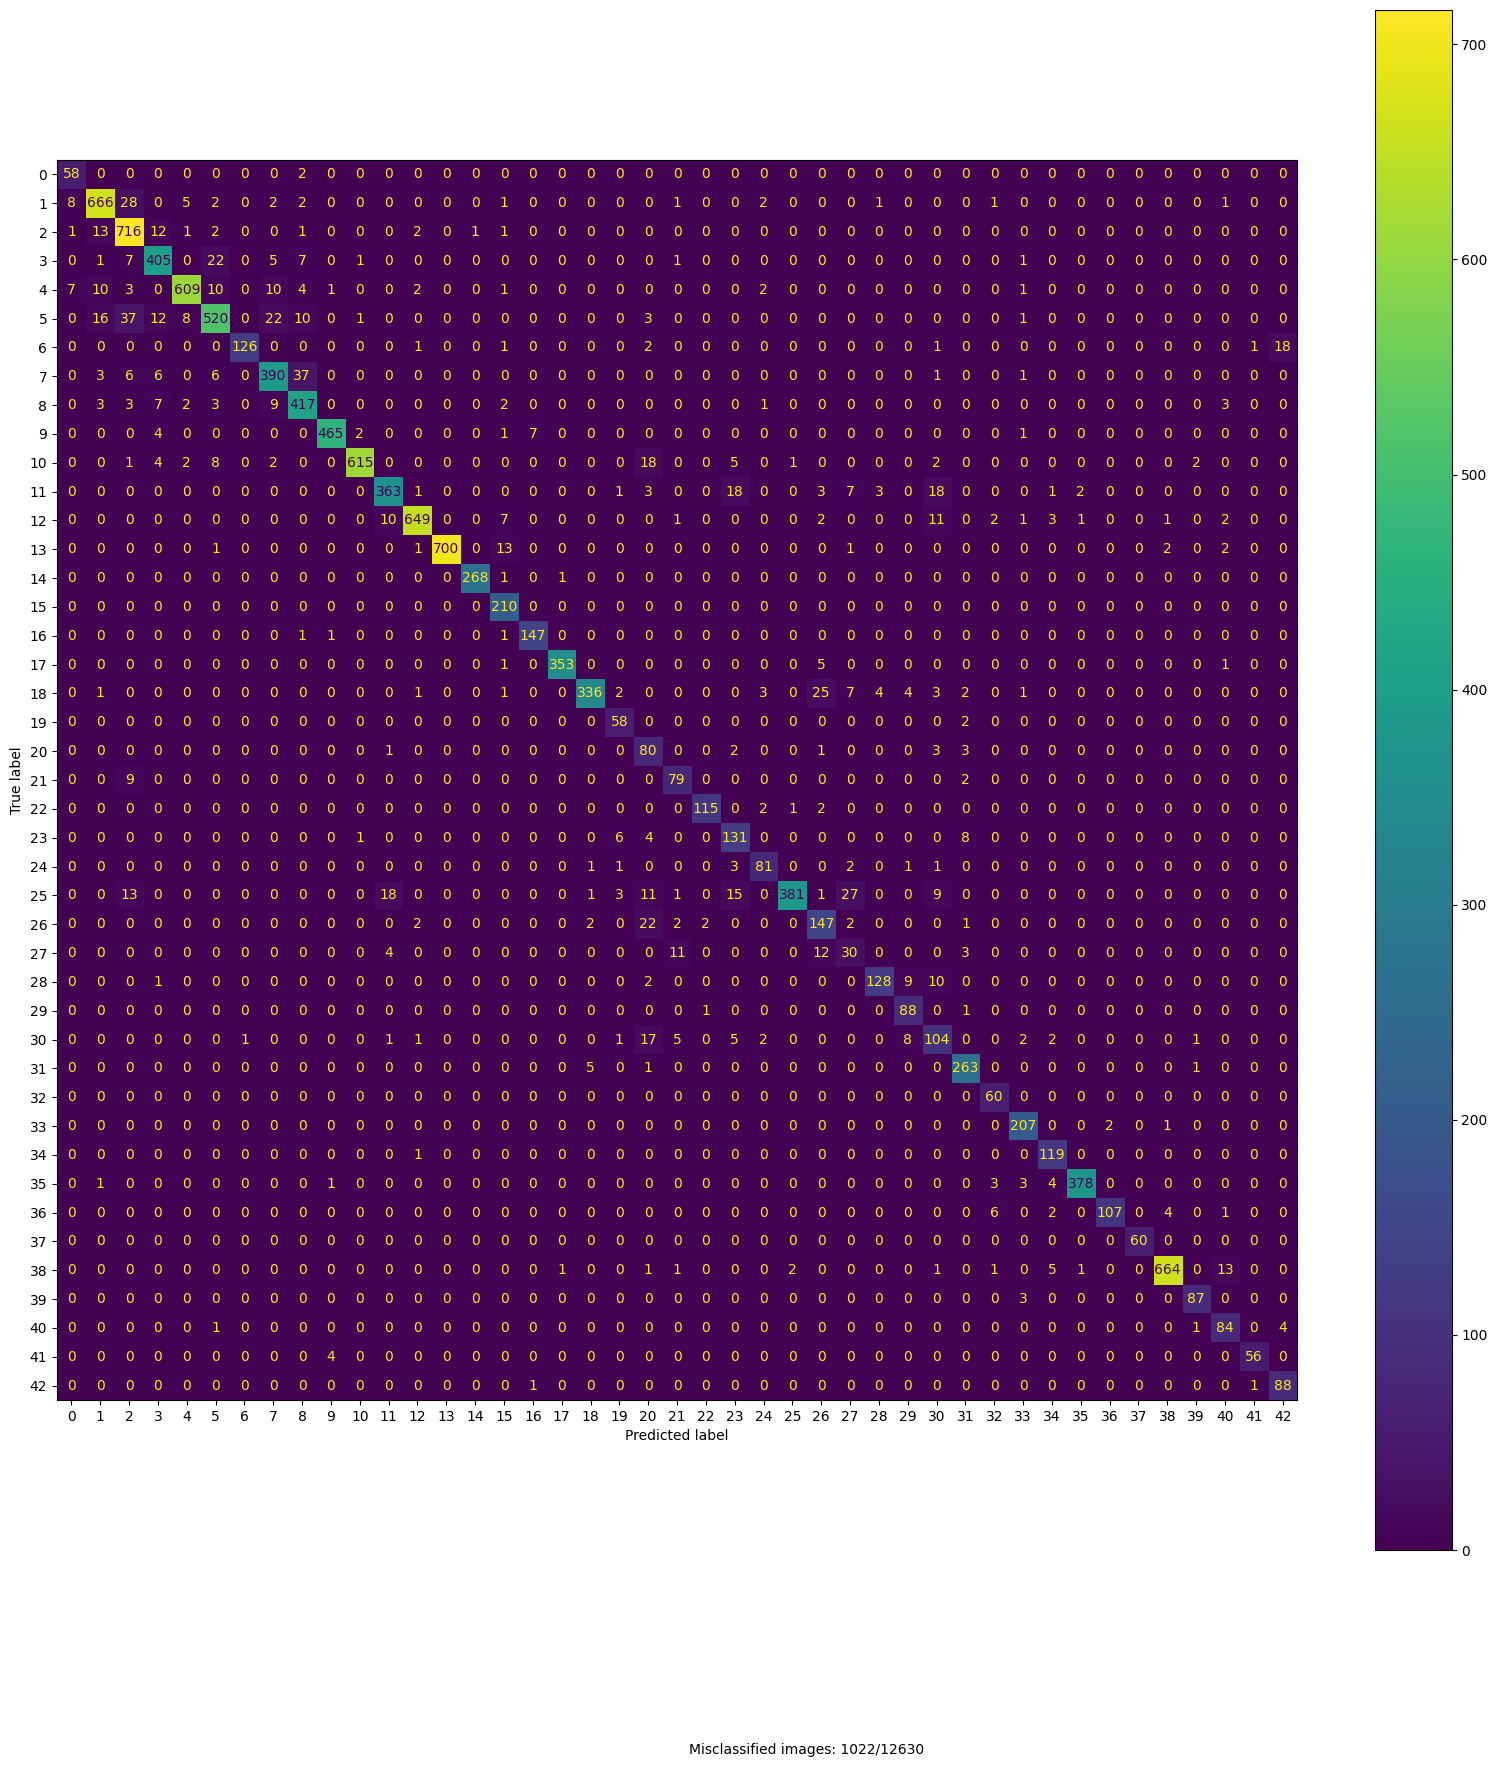

Évaluation du modèle: Random_Forest
Accuracy: 0.9253
Precision: 0.8890
Recall (Sensitivité): 0.9133
F1-score: 0.8973
Spécificité: 0.8890
IoU: 0.8257
ROC AUC: 0.9558

Classification report for model Random_Forest:
              precision    recall  f1-score   support

           0       0.79      0.98      0.87        60
           1       0.94      0.94      0.94       720
           2       0.94      0.94      0.94       750
           3       0.89      0.90      0.89       450
           4       0.95      0.94      0.95       660
           5       0.89      0.89      0.89       630
           6       0.99      0.83      0.90       150
           7       0.94      0.84      0.89       450
           8       0.86      0.93      0.89       450
           9       0.96      0.98      0.97       480
          10       0.98      0.96      0.97       660
          11       0.93      0.86      0.89       420
          12       0.99      0.95      0.97       690
          13       1.00      0

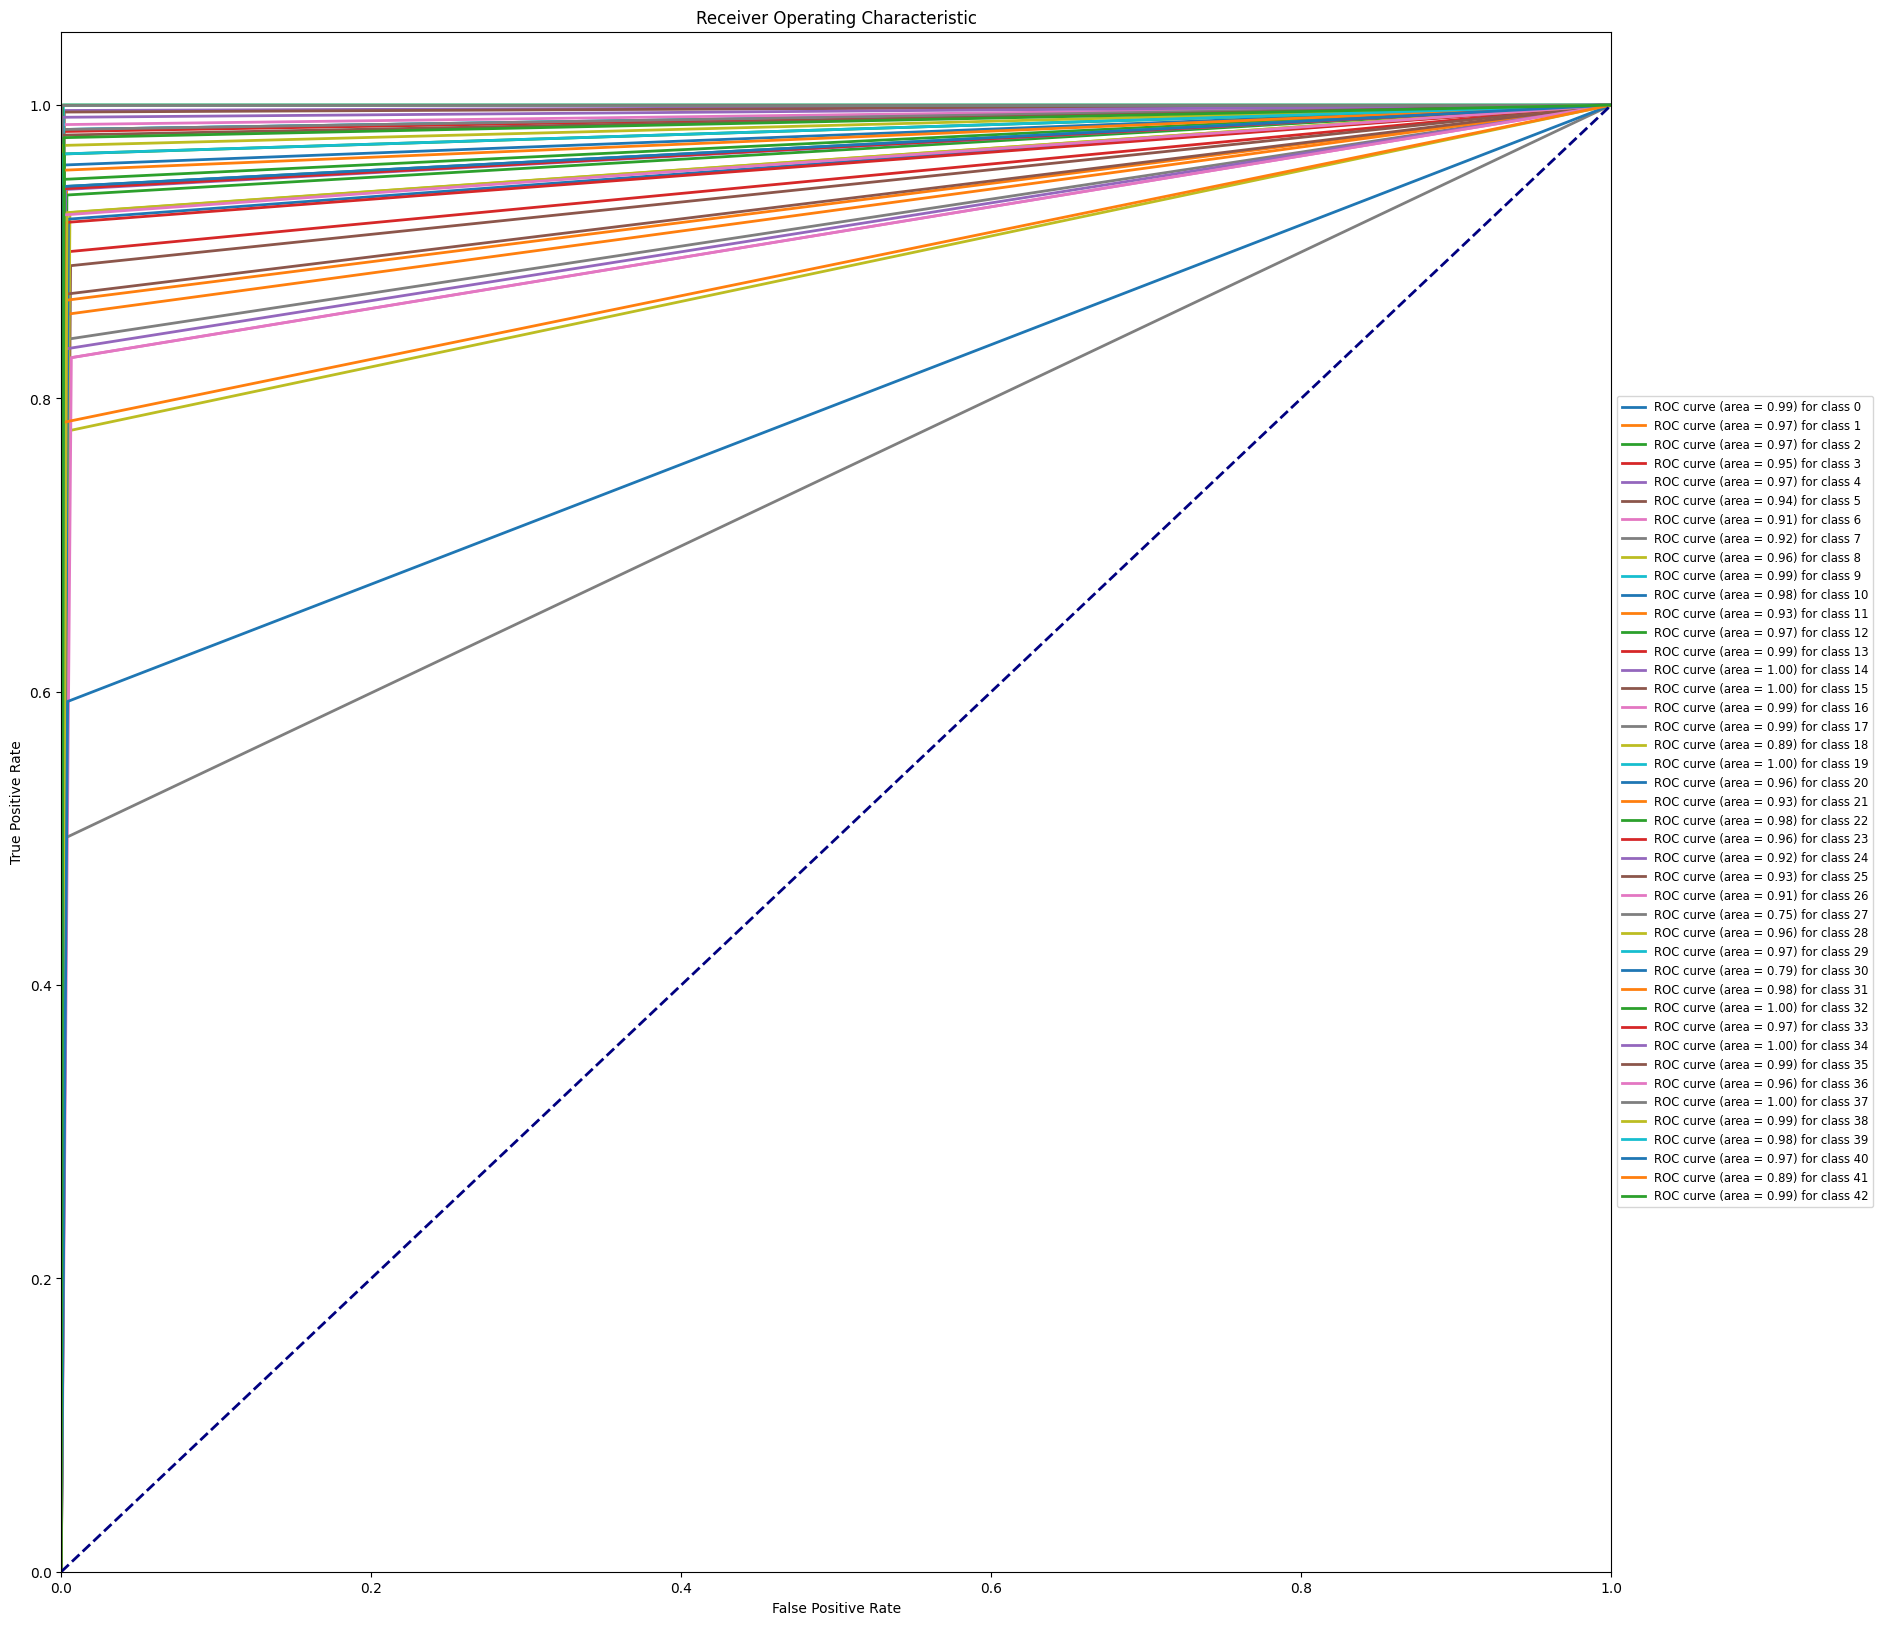

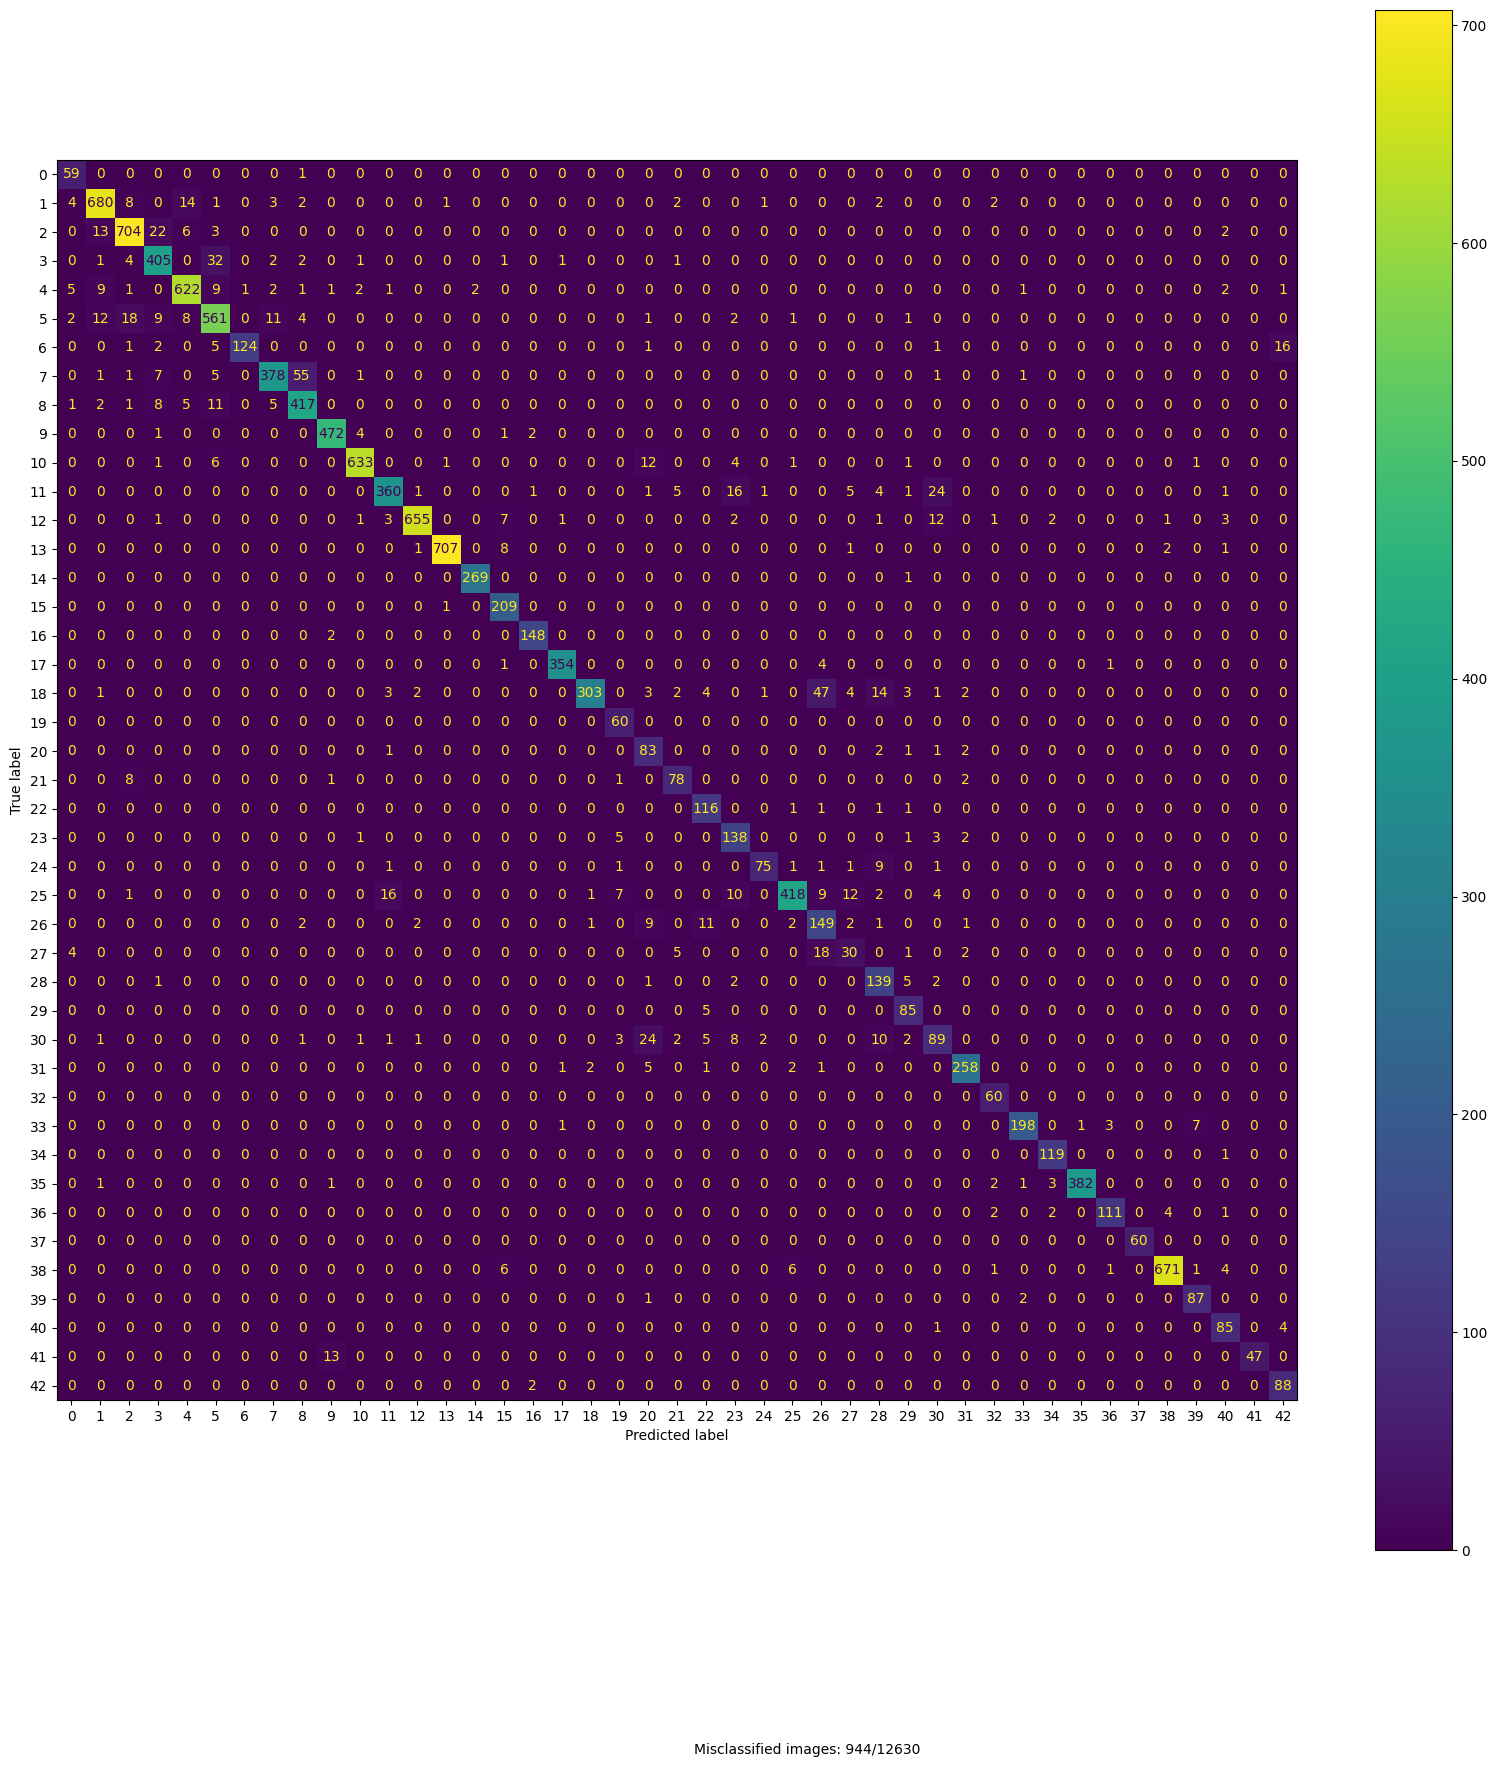

Évaluation du modèle: SVM
Accuracy: 0.9202
Precision: 0.8833
Recall (Sensitivité): 0.9047
F1-score: 0.8897
Spécificité: 0.8833
IoU: 0.8144
ROC AUC: 0.9514

Classification report for model SVM:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        60
           1       0.90      0.95      0.93       720
           2       0.94      0.92      0.93       750
           3       0.88      0.87      0.88       450
           4       0.92      0.94      0.93       660
           5       0.86      0.89      0.88       630
           6       0.99      0.88      0.93       150
           7       0.92      0.85      0.89       450
           8       0.88      0.92      0.90       450
           9       0.97      0.99      0.98       480
          10       0.99      0.95      0.97       660
          11       0.85      0.90      0.88       420
          12       1.00      0.92      0.96       690
          13       0.99      0.99      0.99       

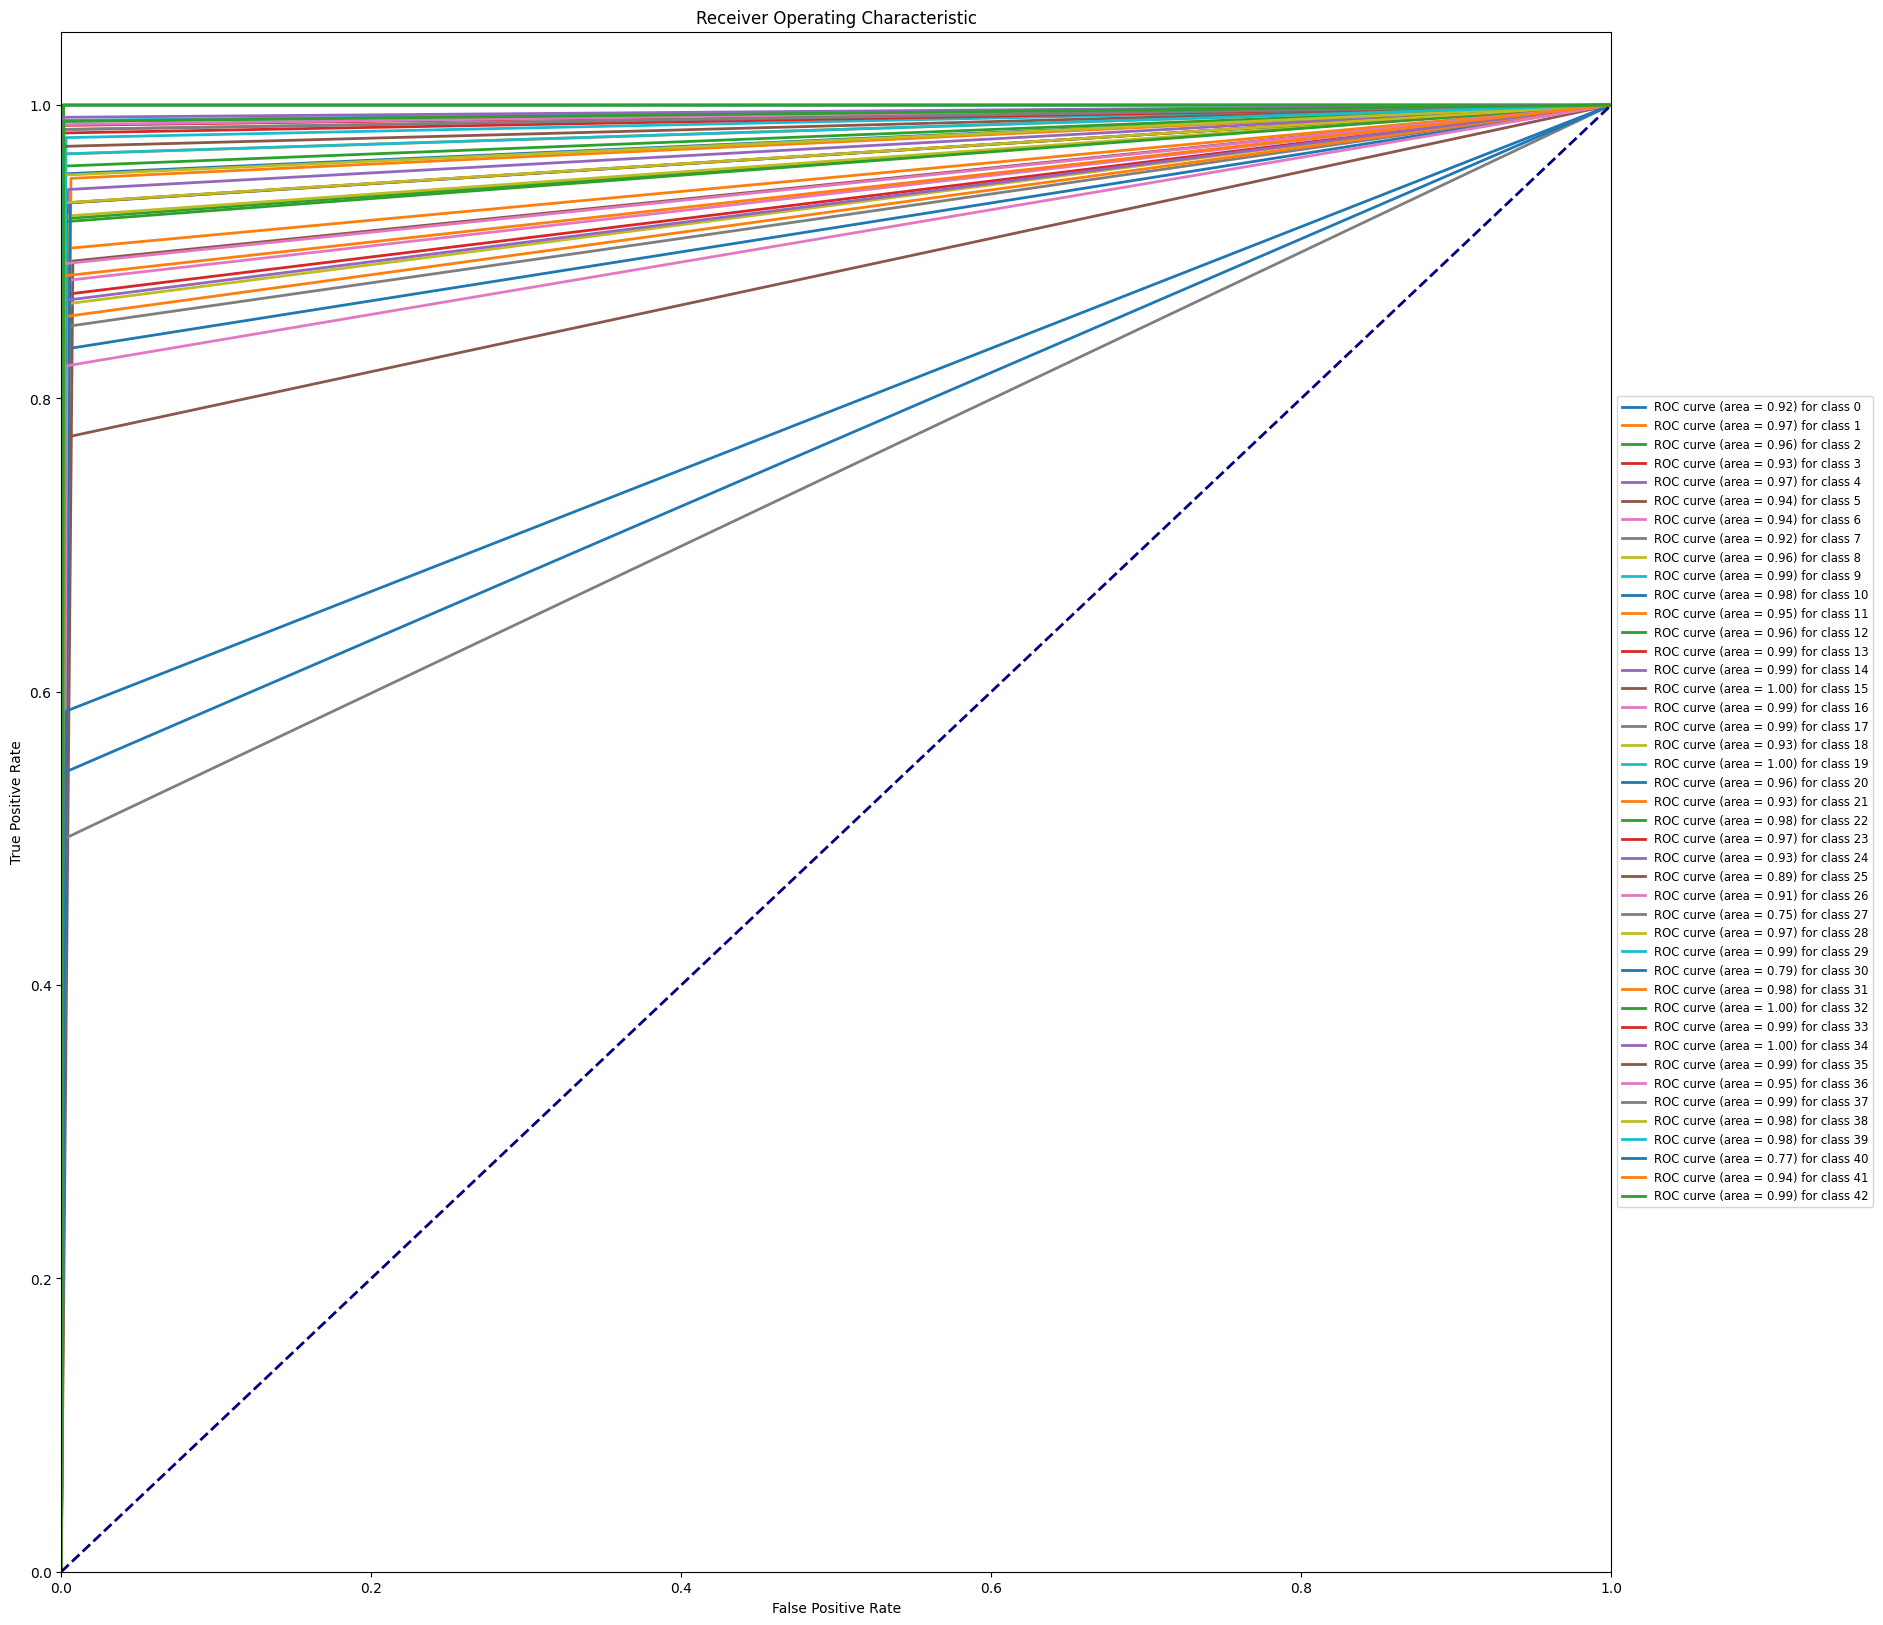

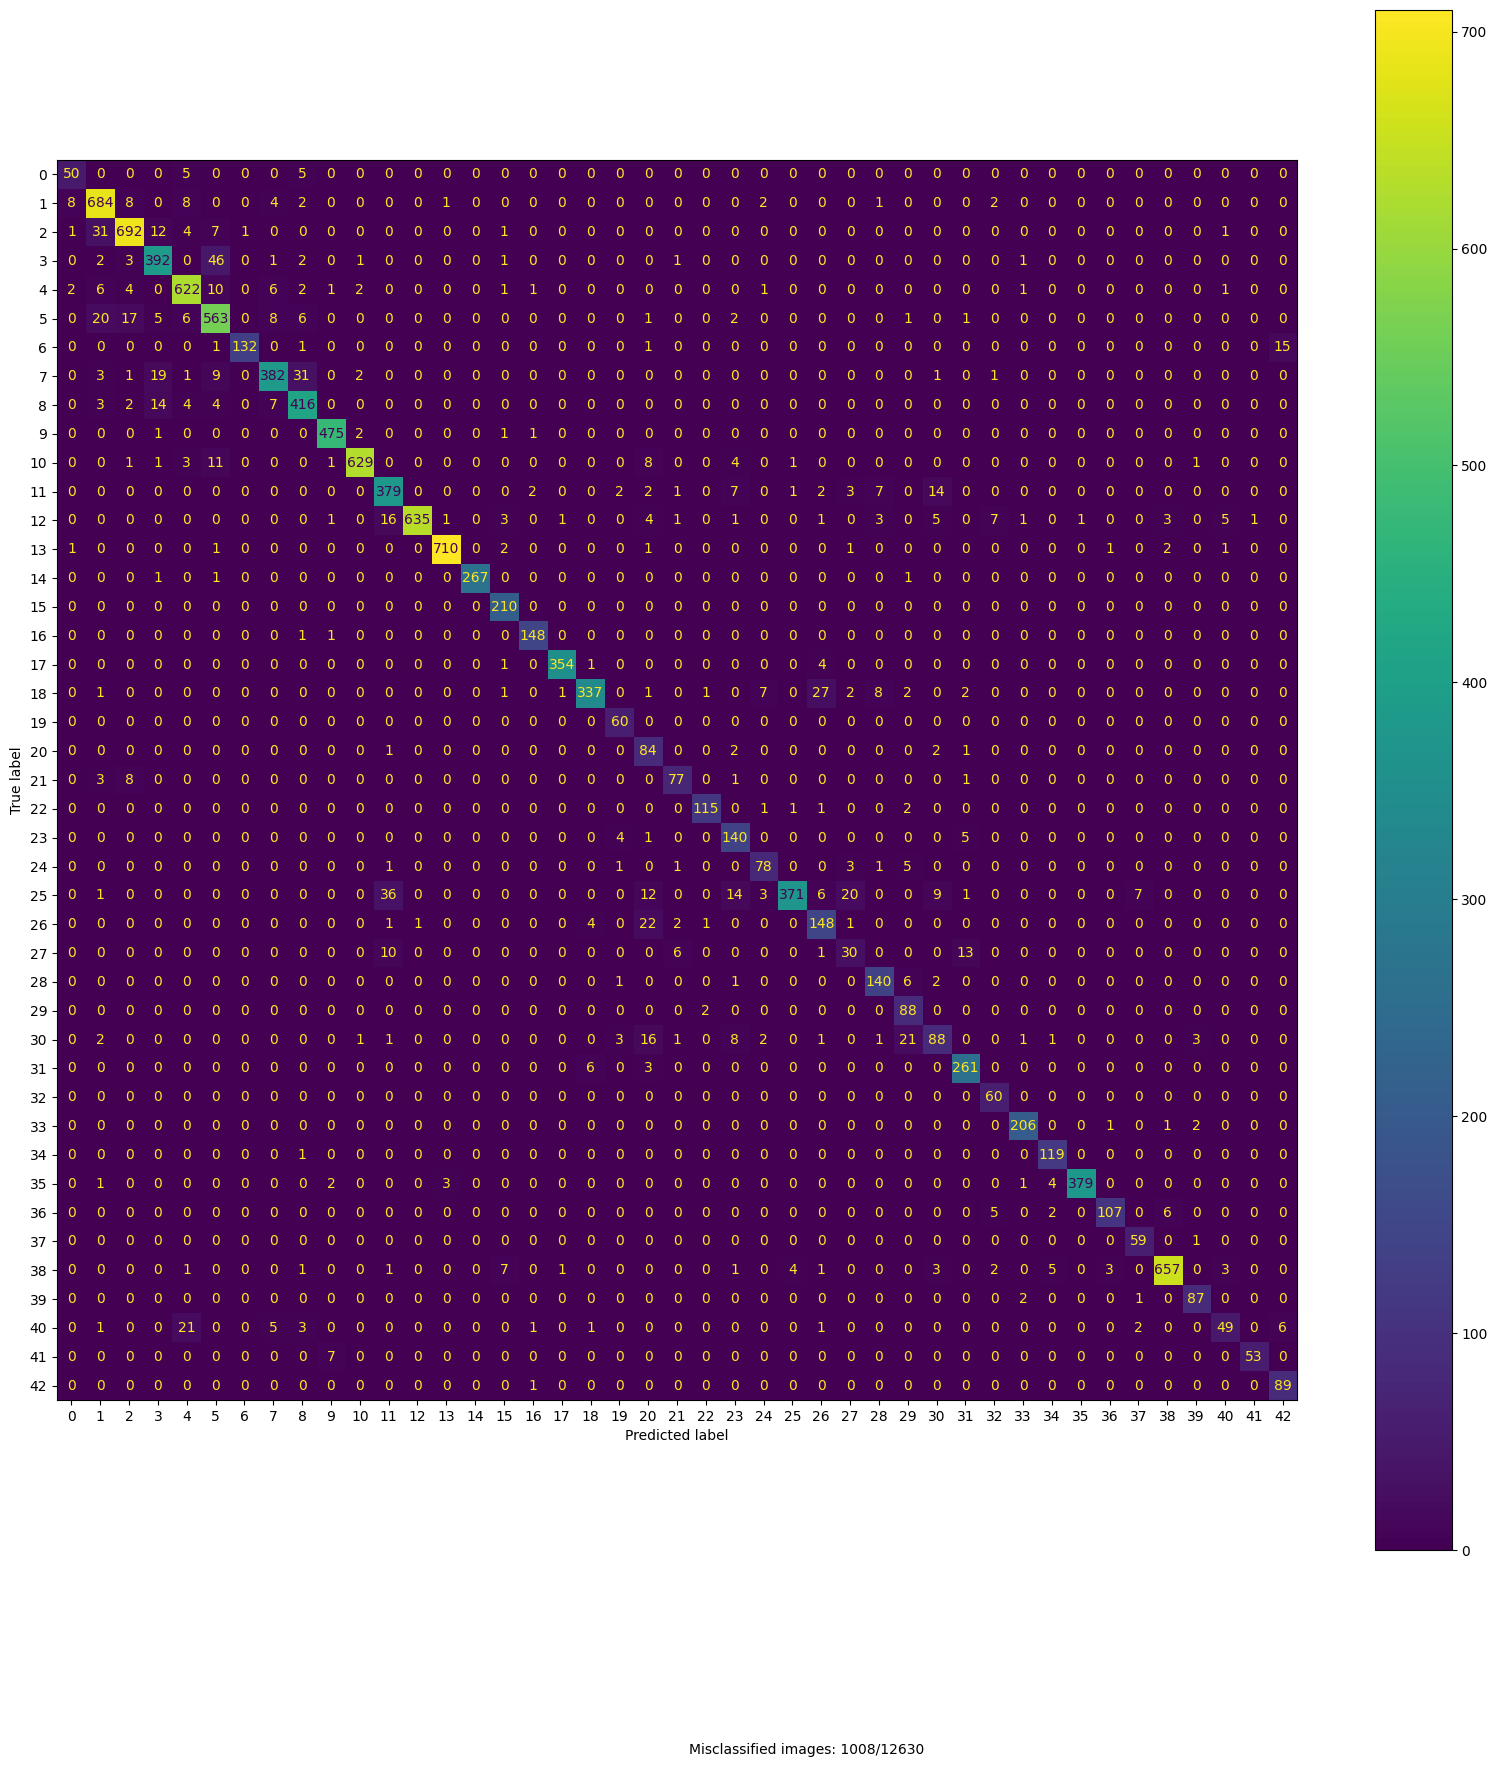

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved reports to disk


In [ ]:
def evaluate_model(model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    tn = np.diag(cm)
    fp = cm.sum(axis=0) - tn
    fn = cm.sum(axis=1) - tn
    tp = tn
    specificity = tn / (tn + fp)
    specificity = np.mean(specificity)
    iou = tp / (tp + fp + fn)
    iou = np.mean(iou)

    # Calcul du ROC AUC basé sur les prédictions binaires
    y_test_bin = label_binarize(y_test, classes=list(range(43)))
    roc_auc = roc_auc_score(y_test_bin, label_binarize(y_pred, classes=list(range(43))), average='macro')

    print(f"Évaluation du modèle: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivité): {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Spécificité: {specificity:.4f}")
    print(f"IoU: {iou:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("")

    cr = classification_report(y_test, y_pred)
    print(f"Classification report for model {model_name}:\n{cr}\n")

    # Afficher le graphique ROC
    plot_roc_curve(y_test, y_pred, 43)

    # Nombre total d'images et nombre d'images mal classées
    total_images = len(y_test)
    correctly_classified = sum(cm[i][i] for i in range(len(cm)))
    misclassified_images = total_images - correctly_classified
    # Redimensionner l'affichage et créer les axes
    fig, ax = plt.subplots(figsize=(20, 20))  # Augmenter la taille de la figure
    # Afficher la matrice de confusion avec la heatmap directement avec la méthode ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis', ax=ax)  # Utiliser un cmap pour la heatmap
    # Ajouter le texte en dehors de la zone de la matrice de confusion avec une taille de police plus petite
    plt.figtext(0.5, 0.01, f"Misclassified images: {misclassified_images}/{total_images}", ha='center', va='center', fontsize=10)
    plt.show()

    # Sauvegarder le rapport de classification et la matrice de confusion
    joblib.dump(cr, f'report_{model_name}.pkl')
    joblib.dump(cm, f'cm_{model_name}.pkl')

# Évaluation des modèles
evaluate_model("CNN", y_test, y_pred_cnn_classes)
evaluate_model("Random_Forest", y_test, y_pred_rf)
evaluate_model("SVM", y_test, y_pred_svm)

# Télécharger le rapport de classification et la matrice de confusion
files.download('report_CNN.pkl')
files.download('cm_CNN.pkl')
files.download('report_Random_Forest.pkl')
files.download('cm_Random_Forest.pkl')
files.download('report_SVM.pkl')
files.download('cm_SVM.pkl')

print("Saved reports to disk")


# Analyses de résultats
Nous observons, à l'aide de la matrice de confusion, que les classes des panneaux indiquant la limite de vitesse sont ceux subissant le plus grand nombre d'erreurs de classement. En effet, ils sont souvent confondus entre eux. Ceci peut s'expliquer par leur ressemblance. Il est possible que la feature extraction n'arrive pas à extraire assez d'informations sur le contenu des panneaux, et se concentre davantage sur la forme de ceux-ci, ou encore que cela soit lié à la difficulté de reconnaître les chiffres spécifiquement sur les panneaux. Ce problème se retrouve sur les 3 modèles que nous avons utilisés et entraînés.

Pour ce qui est des courbes ROC, celles-ci se trouvent toutes au-dessus de la courbe y=x, ce qui montre un modèle plutôt précis (assez proche de 1), sauf pour certaines classes.

En effet :
- Pour la classe 27, plusieurs images contiennent une portion d'un autre panneau, ce qui peut entraîner une confusion pour les modèles
- Pour la classe 30, la plupart des images avec le flocon sont floutées par défaut, ou bien de mauvaise qualité.
- Pour la classe 40, plusieurs panneaux de rond-point sont tagués ou altérés sur les images ce qui explique que le modèle a plus de mal à s'entraîner dessus.

Enfin, pour l'ensemble de nos modèles les métriques obtenues peuvent être considérées comme très bonnes à chaque fois au dessus de 80% (sachant que pour chaque métrique évaluée le meilleur résultat correspond à 100%). Le modèle Random_Forest avec features extraction semble néanmoins légèrement meilleur que le modèle CNN et le modèle SVM avec features extraction pour la détection de panneaux routiers sur des images. Il offre le meilleur équilibre entre précision, rappel, F1-score, spécificité et IoU, tout en ayant une courbe ROC AUC moyenne élevée, et un nombre d'images mal classifiés relativement faibles (inférieur à 10%).


# 5 - Interface utilisateur

Pour l'interface, le code est disponible dans le dossier zip, intitulé interface.py.

Il suffit de télécharger le dossier et de l'extraire, nous avons utilisé VSCode comme IDE (pour le lancer il faut veiller à avoir la bonne version des bibliothèques, notamment tensorflow, sinon cela ne fonctionnera pas avec nos modèles).

A noter que les modèles utilisés dans l'interface correspondent à ceux avec l'extraction de feature suite à la cnn, il s'agit des modèles téléchargés.

Il n'est possible que de tester une image à la fois, le résultat est affiché sous forme de probabilité.

Pour tester les modèles quelques règles vis-à-vis des images à mettre sont à respecter afin que le résultat soit plus ou moins correct :

- Mettre uniquement des panneaux de classes reconnues

- Mettre uniquement des panneaux de format Portable Network Graphics (.png) ou Joint Photographic Experts Group (.jpeg ou .jpg)

- Centrer les panneaux dans les images (nos modèles ne servant que de classification et non pas de détection), par exemple **pas** :

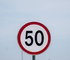

- Ne mettre qu'un seul panneau à la fois, par exemple **pas** :

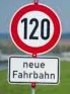

- Mettre des images réelles (les modèles ont été entrainés avec des photographies de panneau et non pas avec des logos), par exemple **pas** :

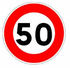

- Préférer mettre des panneaux de face, par exemple **pas** :

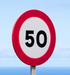

- N'importe quelle taille est admissible du moment que l'image est plus ou moins carrée :  

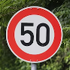

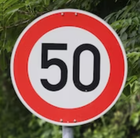

Légendes de l'interface :

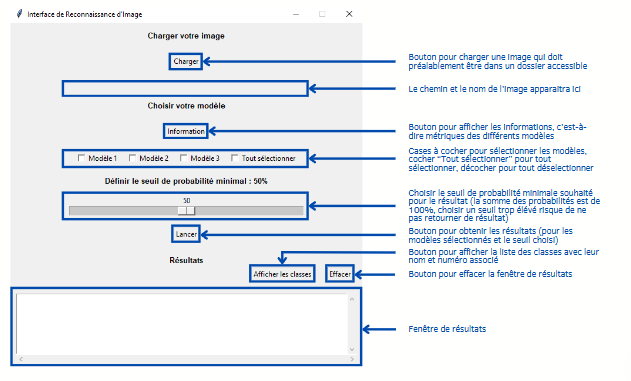

# Liens utiles :
- https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
- https://www.kaggle.com/code/shivank856/gtsrb-cnn-98-test-accuracy
- https://www.kaggle.com/code/yashguptaab99/traffic-sign-classfication
- https://www.kaggle.com/code/hamishdickson/preprocessing-images-with-dimensionality-reduction
- https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
